# Spectral analysis with Gammapy

## Introduction

This notebook explains in detail how to use the classes in [gammapy.spectrum](http://docs.gammapy.org/dev/spectrum/index.html) and related ones. Note, that there is also [spectrum_pipe.ipynb](spectrum_pipe.ipynb) which explains how to do the analysis using a high-level interface. This notebook is aimed at advanced users who want to script taylor-made analysis pipelines and implement new methods.

Based on a datasets of 4 Crab observations with H.E.S.S. (simulated events for now) we will perform a full region based spectral analysis, i.e. extracting source and background counts from certain 
regions, and fitting them using the forward-folding approach. We will use the following classes

Data handling:

* [gammapy.data.DataStore](http://docs.gammapy.org/dev/api/gammapy.data.DataStore.html)
* [gammapy.data.DataStoreObservation](http://docs.gammapy.org/dev/api/gammapy.data.DataStoreObservation.html)
* [gammapy.data.ObservationStats](http://docs.gammapy.org/dev/api/gammapy.data.ObservationStats.html)
* [gammapy.data.ObservationSummary](http://docs.gammapy.org/dev/api/gammapy.data.ObservationSummary.html)

To extract the 1-dim spectral information:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumExtraction](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumExtraction.html)
* [gammapy.background.ReflectedRegionsBackgroundEstimator](http://docs.gammapy.org/dev/api/gammapy.background.ReflectedRegionsBackgroundEstimator.html)


For the global fit (using Sherpa and WSTAT in the background):

* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumFit.html)
* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.spectrum.models.ExponentialCutoffPowerLaw](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.ExponentialCutoffPowerLaw.html)
* [gammapy.spectrum.models.LogParabola](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.LogParabola.html)

To compute flux points (a.k.a. "SED" = "spectral energy distribution")

* [gammapy.spectrum.SpectrumResult](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumResult.html)
* [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPoints.html)
* [gammapy.spectrum.SpectrumEnergyGroupMaker](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumEnergyGroupMaker.html)
* [gammapy.spectrum.FluxPointEstimator](http://docs.gammapy.org/dev/api/gammapy.spectrum.FluxPointEstimator.html)

Feedback welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions
import sherpa

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("sherpa", sherpa.__version__)

gammapy: 0.8.dev7295
numpy: 1.16.0.dev0+65f15a5
astropy 3.0.4
regions 0.3
sherpa 4.10.0


In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import vstack as vstack_table
from regions import CircleSkyRegion
from gammapy.data import DataStore, ObservationList
from gammapy.data import ObservationStats, ObservationSummary
from gammapy.background.reflected import ReflectedRegionsBackgroundEstimator
from gammapy.utils.energy import EnergyBounds
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumObservation,
    SpectrumFit,
    SpectrumResult,
)
from gammapy.spectrum.models import (
    PowerLaw,
    ExponentialCutoffPowerLaw,
    LogParabola,
)
from gammapy.spectrum import (
    FluxPoints,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.maps import Map

## Configure logger

Most high level classes in gammapy have the possibility to turn on logging or debug output. We well configure the logger in the following. For more info see https://docs.python.org/2/howto/logging.html#logging-basic-tutorial

In [4]:
# Setup the logger
import logging

logging.basicConfig()
logging.getLogger("gammapy.spectrum").setLevel("WARNING")

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula (simulated events for now).

We will access the events, effective area, energy dispersion, livetime and PSF for containement correction.

In [5]:
datastore = DataStore.from_dir("../datasets/hess-dl3-dr1/")
obs_ids = [23523, 23526, 23559, 23592]
obs_list = datastore.obs_list(obs_ids)

## Define Target Region

The next step is to define a signal extraction region, also known as on region. In the simplest case this is just a [CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), but here we will use the ``Target`` class in gammapy that is useful for book-keeping if you run several analysis in a script.

In [6]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region.
To make sure the off regions don't contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there's only one known gamma-ray source near the Crab nebula: the AGN called [RGB J0521+212](http://gamma-sky.net/#/cat/tev/23) at GLON = 183.604 deg and GLAT = -8.708 deg.

(<matplotlib.figure.Figure at 0x7f3435e987f0>,
 None)

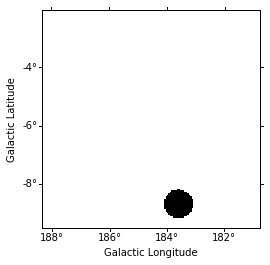

In [7]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", coordsys="GAL"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot()

## Estimate background

Next we will manually perform a background estimate by placing [reflected regions](http://docs.gammapy.org/dev/background/reflected.html) around the pointing position and looking at the source statistics. This will result in a  [gammapy.background.BackgroundEstimate](http://docs.gammapy.org/dev/api/gammapy.background.BackgroundEstimate.html) that serves as input for other classes in gammapy.

In [8]:
background_estimator = ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list, on_region=on_region, exclusion_mask=exclusion_mask
)

background_estimator.run()

In [9]:
# print(background_estimator.result[0])

/home/hfm/adonath/Software/Applications/anaconda3.5/envs/gammapy-dev/lib/python3.6/site-packages/matplotlib/patches.py:91: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


(<matplotlib.figure.Figure at 0x7f34404bb438>,
 None)

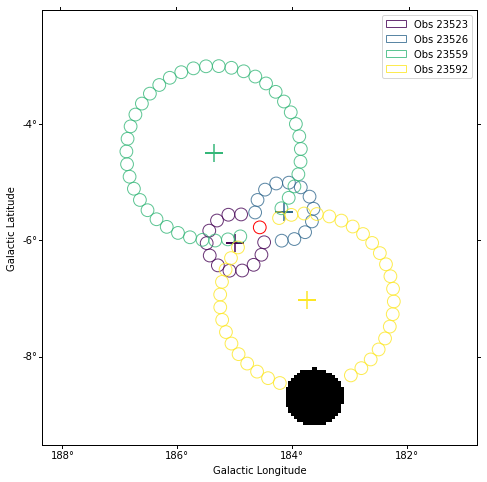

In [10]:
plt.figure(figsize=(8, 8))
background_estimator.plot()

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the [ObservationSummary](http://docs.gammapy.org/dev/api/gammapy.data.ObservationSummary.html#gammapy.data.ObservationSummary) class.

*** Observation summary report ***
Observation Id: 23526
Livetime: 0.437 h
On events: 201
Off events: 225
Alpha: 0.083
Bkg events in On region: 18.75
Excess: 182.25
Excess / Background: 9.72
Gamma rate: 7.67 1 / min
Bkg rate: 0.72 1 / min
Sigma: 21.86



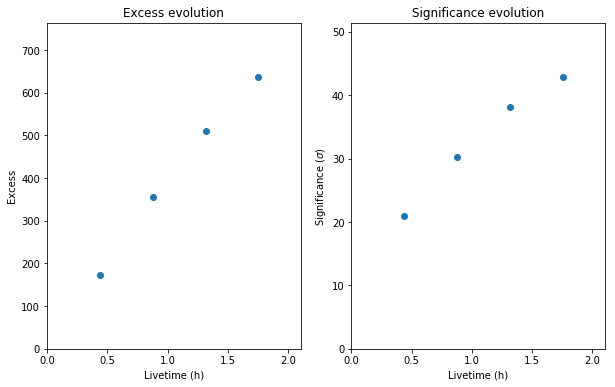

In [11]:
stats = []
for obs, bkg in zip(obs_list, background_estimator.result):
    stats.append(ObservationStats.from_obs(obs, bkg))

print(stats[1])

obs_summary = ObservationSummary(stats)
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)

obs_summary.plot_excess_vs_livetime(ax=ax1)
ax2 = fig.add_subplot(122)
obs_summary.plot_significance_vs_livetime(ax=ax2)

## Extract spectrum

Now, we're going to extract a spectrum using the [SpectrumExtraction](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumExtraction.html) class. We provide the reconstructed energy binning we want to use. It is expected to be a Quantity with unit energy, i.e. an array with an energy unit. We use a utility function to create it. We also provide the true energy binning to use.

In [12]:
e_reco = EnergyBounds.equal_log_spacing(0.1, 40, 40, unit="TeV")
e_true = EnergyBounds.equal_log_spacing(0.05, 100., 200, unit="TeV")

Instantiate a [SpectrumExtraction](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumExtraction.html) object that will do the extraction. The containment_correction parameter is there to allow for PSF leakage correction if one is working with full enclosure IRFs. We also compute a threshold energy and store the result in OGIP compliant files (pha, rmf, arf). This last step might be omitted though.

In [13]:
ANALYSIS_DIR = "crab_analysis"

extraction = SpectrumExtraction(
    obs_list=obs_list,
    bkg_estimate=background_estimator.result,
    containment_correction=False,
)
extraction.run()

# Add a condition on correct energy range in case it is not set by default
extraction.compute_energy_threshold(method_lo="area_max", area_percent_lo=10.0)

print(extraction.observations[0])
# Write output in the form of OGIP files: PHA, ARF, RMF, BKG
# extraction.run(obs_list=obs_list, bkg_estimate=background_estimator.result, outdir=ANALYSIS_DIR)

*** Observation summary report ***
Observation Id: 23523
Livetime: 0.439 h
On events: 125
Off events: 98
Alpha: 0.083
Bkg events in On region: 8.17
Excess: 116.83
Excess / Background: 14.31
Gamma rate: 0.07 1 / s
Bkg rate: 0.01 1 / min
Sigma: 18.74
energy range: 0.88 TeV - 100.00 TeV


## Look at observations

Now we will look at the files we just created. We will use the [SpectrumObservation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html) object that are still in memory from the extraction step. Note, however, that you could also read them from disk if you have written them in the step above. The ``ANALYSIS_DIR`` folder contains 4 ``FITS`` files for each observation. These files are described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html). In short, they correspond to the on vector, the off vector, the effectie area, and the energy dispersion.

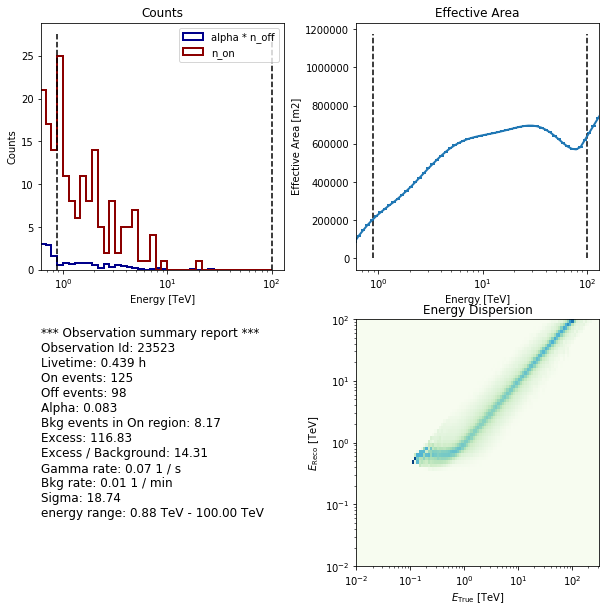

In [14]:
# filename = ANALYSIS_DIR + '/ogip_data/pha_obs23523.fits'
# obs = SpectrumObservation.read(filename)

# Requires IPython widgets
# _ = extraction.observations.peek()

extraction.observations[0].peek()

## Fit spectrum

Now we'll fit a global model to the spectrum. First we do a joint likelihood fit to all observations. If you want to stack the observations see below. We will also produce a debug plot in order to show how the global fit matches one of the individual observations.

In [15]:
model = PowerLaw(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

joint_fit = SpectrumFit(obs_list=extraction.observations, model=model)
joint_fit.run()
joint_result = joint_fit.result


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.663e+00 7.100e-02                       nan nan
	amplitude 2.912e-11 1.782e-12 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name           index               amplitude        reference
	--------- --------------------- ---------------------- ---------
	    index  0.005041573867108919  7.188783900813557e-14       0.0
	amplitude 7.188783900813557e-14 3.1763364158668058e-24       0.0
	reference                   0.0                    0.0       0.0 

Statistic: 42.226 (wstat)
Fit Range: [  0.87992254 100.        ] TeV



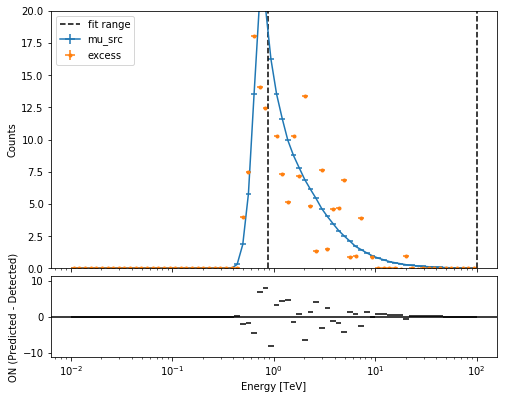

In [16]:
ax0, ax1 = joint_result[0].plot(figsize=(8, 8))
ax0.set_ylim(0, 20)
print(joint_result[0])

## Compute Flux Points

To round up out analysis we can compute flux points by fitting the norm of the global model in energy bands. We'll use a fixed energy binning for now.

In [17]:
# Define energy binning
ebounds = [0.3, 1.1, 3, 10.1, 30] * u.TeV

stacked_obs = extraction.observations.stack()

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_groups_fixed(ebounds=ebounds)

print(seg.groups)

SpectrumEnergyGroups:
energy_group_idx bin_idx_min bin_idx_max  bin_type      energy_min          energy_max    
                                                           TeV                 TeV        
---------------- ----------- ----------- --------- ------------------- -------------------
               0           0          26 underflow                0.01 0.31622776601683794
               1          27          36    normal 0.31622776601683794  1.1364636663857242
               2          37          44    normal  1.1364636663857242  3.1622776601683795
               3          45          53    normal  3.1622776601683795                10.0
               4          54          62    normal                10.0  31.622776601683793
               5          63          71  overflow  31.622776601683793               100.0



In [18]:
fpe = FluxPointEstimator(
    obs=stacked_obs, groups=seg.groups, model=joint_result[0].model
)
fpe.compute_points()

e_ref,e_min,e_max,dnde,dnde_err,dnde_ul,is_ul,sqrt_ts,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,bool,float64,float64,float64
0.5994842503189408,0.31622776601683794,1.1364636663857242,1.0544767096804167e-10,9.39217739896939e-12,1.2525213546699175e-10,False,21.62263496471706,nan,nan
1.8957356524063753,1.1364636663857242,3.1622776601683795,5.732192985229167e-12,4.029889063212435e-13,6.580954700407496e-12,False,27.277621428681453,nan,nan
5.623413251903491,3.1622776601683795,10.0,2.8691252511376034e-13,3.8010940855799383e-14,3.6879525430713757e-13,False,14.15566779459286,nan,nan
17.78279410038923,10.0,31.622776601683793,8.18648342869576e-15,3.320772855487258e-15,1.6435757097266973e-14,False,4.271049984774234,nan,nan


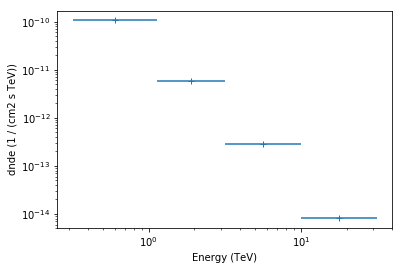

In [19]:
fpe.flux_points.plot()
fpe.flux_points.table

The final plot with the best fit model and the flux points can be quickly made like this

(0.4, 50)

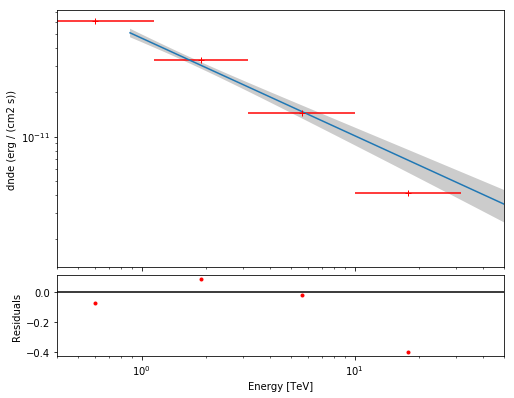

In [20]:
spectrum_result = SpectrumResult(
    points=fpe.flux_points, model=joint_result[0].model
)
ax0, ax1 = spectrum_result.plot(
    energy_range=joint_fit.result[0].fit_range,
    energy_power=2,
    flux_unit="erg-1 cm-2 s-1",
    fig_kwargs=dict(figsize=(8, 8)),
    point_kwargs=dict(color="red"),
)

ax0.set_xlim(0.4, 50)

## Stack observations

And alternative approach to fitting the spectrum is stacking all observations first and the fitting a model to the stacked observation. This works as follows. A comparison to the joint likelihood fit is also printed.

In [21]:
stacked_obs = extraction.observations.stack()

stacked_fit = SpectrumFit(obs_list=stacked_obs, model=model)
stacked_fit.run()

FitResult

	backend    : minuit
	method    : None
	success    : True
	nfev       : 58
	total stat : 30.31
	message    : Optimization terminated successfully.

In [22]:
stacked_result = stacked_fit.result
print(stacked_result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error         unit         min    max
	--------- --------- --------- --------------- --------- ---
	    index 2.667e+00 7.147e-02                       nan nan
	amplitude 2.909e-11 1.784e-12 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00 0.000e+00             TeV 0.000e+00 nan

Covariance: 

	   name          index               amplitude       reference
	--------- -------------------- --------------------- ---------
	    index 0.005108148891209261  7.24054791981601e-14       0.0
	amplitude 7.24054791981601e-14 3.183437347088229e-24       0.0
	reference                  0.0                   0.0       0.0 

Statistic: 30.311 (wstat)
Fit Range: [  0.68129207 100.        ] TeV



In [23]:
stacked_table = stacked_result[0].to_table(format=".3g")
stacked_table["method"] = "stacked"
joint_table = joint_result[0].to_table(format=".3g")
joint_table["method"] = "joint"
total_table = vstack_table([stacked_table, joint_table])
print(
    total_table["method", "index", "index_err", "amplitude", "amplitude_err"]
)

 method index index_err    amplitude     amplitude_err 
                        1 / (cm2 s TeV) 1 / (cm2 s TeV)
------- ----- --------- --------------- ---------------
stacked  2.67    0.0715        2.91e-11        1.78e-12
  joint  2.66     0.071        2.91e-11        1.78e-12


## Exercises

Some things we might do:

- Fit a different spectral model (ECPL or CPL or ...)
- Use different method or parameters to compute the flux points
- Do a chi^2 fit to the flux points and compare

TODO: give pointers how to do this (and maybe write a notebook with solutions)

In [24]:
# Start exercises here

## What next?

In this tutorial we learned how to extract counts spectra from an event list and generate the corresponding IRFs. Then we fitted a model to the observations and also computed flux points.

Here's some suggestions where to go next:

* if you want think this is way too complicated and just want to run a quick analysis check out [this notebook](spectrum_pipe.ipynb)
* if you interested in available fit statistics checkout [gammapy.stats](http://docs.gammapy.org/dev/stats/index.html)